# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
plt.rcParams.update({
    'font.family':'cmr10',
    'mathtext.fontset': 'cm',
    'axes.formatter.use_mathtext': True,
    'axes.axisbelow': True,
    'figure.figsize': [6.0, 6.0],
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.size':15,
    'savefig.directory':'./Images'
})

### Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

#### Soluzione 07.1
Includo del codice di NSL simulator l'implementazione delle tail correction come segue:
``` c++
_vtail = 8.0 * M_PI * _rho *((1/(9.0*pow(_r_cut,9))) - (1/(3.0*pow(_r_cut,3))));
_ptail = 32.0 * M_PI * _rho / ((1/9.0*pow(_r_cut,9)) - (1/6.0*pow(_r_cut,3)));
```
rispettivamente nell'inizializzazione dell'energia potenziale e della pressione.

### Exercise 07.2

Use the NSL simulator code to print out **instantaneous** values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo $(N,V,T)$ and Molecular Dynamics $(N,V,E)$ simulations of $M=5\times 10^5$ MC steps or MD time steps (where, for MC, the Metropolis acceptance ratio should be fixed approximately to 50% by changing the value of $dt$ that, in the MC case, represent the amplitude of the step in each direction) in the following thermodynamic conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r^\star_c = 2.5$, for MD $dt^\star=0.001$)

Equilibration is needed both with MC and with MD. With MD, you will observe that starting from a perfect crystalline configuration the temperature, $T$, will not conserve its value. Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$.
Perform your MC and MD simulations by re-starting after such equilibration time.

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

#### Solution 07.2
Partendo dalle simulazioni di Molecular Dynamics (MD), fissiamo una temperatura $(T=1.98)$ tale che dopo l'equilibrazione il sistema raggiunga la temperatura richiesta parti a $T^* = 1.1$. Per equilibrare il sistema lo facciamo evolvere con i seguenti parametri:
- $N_{blocks} = 200$
- $N_{steps} = 1000$ (passi per blocco) 

Alla fine dell'equilibrazione prendiamo le configurazini finali raggiunte e le utilizziamo come configurazioni iniziali per la prossima simulazione.

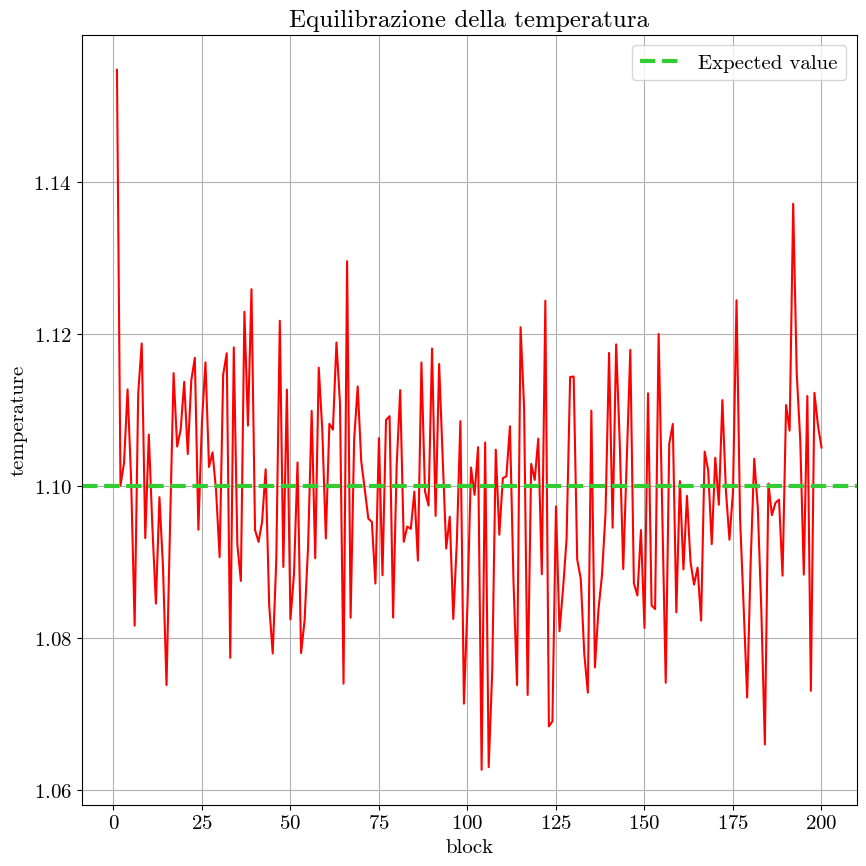

In [12]:
temp = np.loadtxt("NSL_SIMULATOR/OUTPUT/MD/temperature_equil.dat")
x = temp[:,0]
y = temp[:,1]

plt.figure(1, figsize=(10,10))
plt.plot(x,y, color='red')
plt.xlabel('block')
plt.ylabel('temperature')
plt.title('Equilibrazione della temperatura')
plt.axhline(y=1.1, color='limegreen', linestyle='--', linewidth = 3, label = 'Expected value')
plt.legend()

plt.grid(True)

Per quanto riguarda le simulazioni Monte Carlo (MC) dobbiamo scegliere il passo $dt$ in modo che l'accettanza sia al $50\%$, modifichiamo quindi il valore di dt finchè l'accettanza non raggiunge il valore desiderato.
Per $dt = 1$ otteniamo il seguente andamento per l'accettazione:

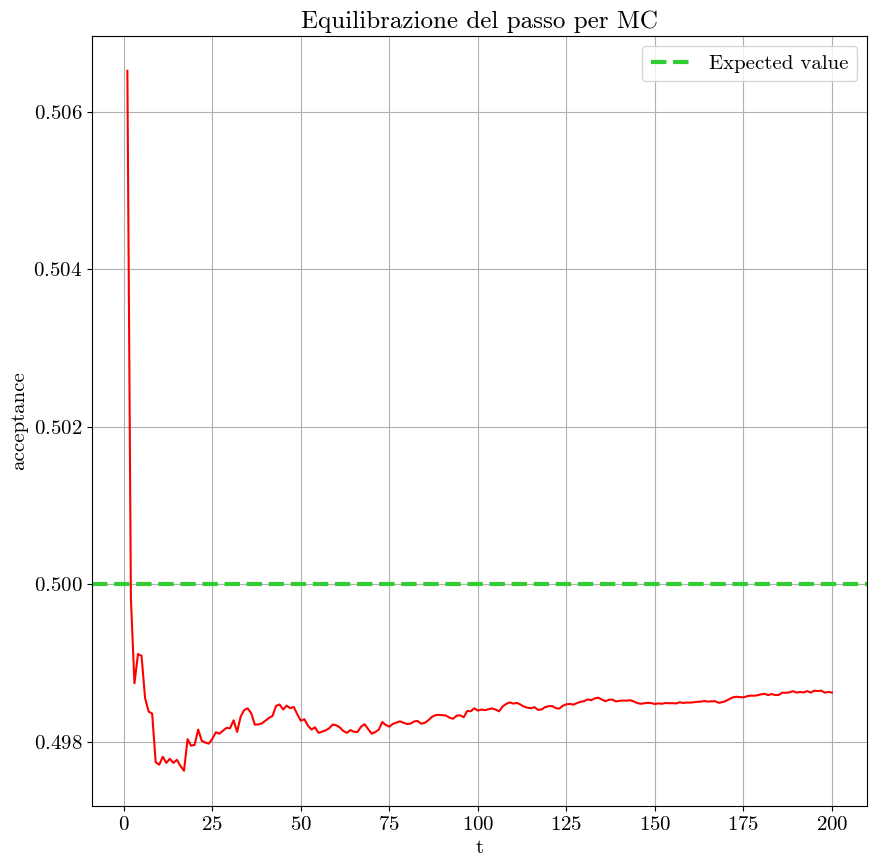

In [13]:
temp = np.loadtxt("NSL_SIMULATOR/OUTPUT/MC/acceptance_equil.dat")
x = temp[:,0]
y = temp[:,1]

plt.figure(1, figsize=(10,10))
plt.plot(x,y, color='red')
plt.xlabel('t')
plt.ylabel('acceptance')
plt.title('Equilibrazione del passo per MC')
plt.axhline(y=0.5, color='limegreen', linestyle='--', linewidth = 3, label = 'Expected value')
plt.legend()

plt.grid(True)

Negli esercizi precedenti abbiamo applicato il data blocking per fare in modo che i risultati ottenuti non fossero influenzati da correlazioni dovute alla non completa casualità del generatore di numeri casuali. Vogliamo quindi determinare quale sia la dimensione ottimale dei blocchi affinché si annulli la correlazione tra i numeri estratti. A tal fine, dopo aver equilibrato il sistema come descritto sopra, eseguiamo una simulazione impostando a 1 il numero di passi per blocco $(𝑁_{steps}=1)$, così da poter studiare la correlazione tra i valori ottenuti da singole estrazioni. Implementiamo il calcolo dell’autocorrelazione tra i valori di energia potenziale secondo la seguente definizione:

$$ \chi(t) = 
\frac{
\frac{1}{t_{max}} \sum_{t'=0}^{t_{max}} m(t') m(t'+t) - 
\left( \frac{1}{t_{max}} \sum_{t'=0}^{t_{max}} m(t') \right)
\left( \frac{1}{t_{max}} \sum_{t'=0}^{t_{max}} m(t'+t) \right)
}{
\frac{1}{t_{max}} \sum_{t'=0}^{t_{max}} m^2(t') - 
\left( \frac{1}{t_{max}} \sum_{t'=0}^{t_{max}} m(t') \right)^2
}
$$

Eseguiamo le simulazioni sia MD che MD e otteniamo i seguenti grafici per $\chi(t)$:



In [24]:
#Molecular Dynamics
potential = np.loadtxt('NSL_SIMULATOR/OUTPUT/MD/potential_energy_for_acf.dat')
p = potential[:,1]

p = np.asarray(p, dtype=float)
t_max = p.size
print(t_max)
# Denominatore varianza 
mean_all = p.mean()

denom = (p**2).mean() - mean_all**2
if denom == 0:
    raise ValueError("Denominatore nullo (varianza = 0), autocorrelazione non definita.")

# Costruiamo il vettore di autocorrelazione per lag t = 0,1,...,N-1
chi = np.zeros(t_max)
for t in range(t_max):
    M = t_max - t
    segment1 = p[:M]
    segment2 = p[t:]
    # ⟨m(i)m(i+t)⟩
    avg_prod = np.dot(segment1, segment2) / M
    # ⟨m(i)⟩ e ⟨m(i+t)⟩
    avg1 = segment1.mean()

    avg2 = segment2.mean()
    # valore di χ(t)
    chi[t] = (avg_prod - avg1*avg2) / denom


500000


In [23]:
#Monte Carlo
potential = np.loadtxt('NSL_SIMULATOR/OUTPUT/MC/potential_energy_for_acf.dat')
p = potential[:,1]

p = np.asarray(p, dtype=float)
t_max = p.size
print(t_max)
# Denominatore varianza 
mean_all = p.mean()

denom = (p**2).mean() - mean_all**2
if denom == 0:
    raise ValueError("Denominatore nullo (varianza = 0), autocorrelazione non definita.")

# Costruiamo il vettore di autocorrelazione per lag t = 0,1,...,N-1
chi_2 = np.zeros(t_max)
for t in range(t_max):
    M = t_max - t
    segment1 = p[:M]
    segment2 = p[t:]
    # ⟨m(i)m(i+t)⟩
    avg_prod = np.dot(segment1, segment2) / M
    # ⟨m(i)⟩ e ⟨m(i+t)⟩
    avg1 = segment1.mean()

    avg2 = segment2.mean()
    # valore di χ(t)
    chi_2[t] = (avg_prod - avg1*avg2) / denom


500000


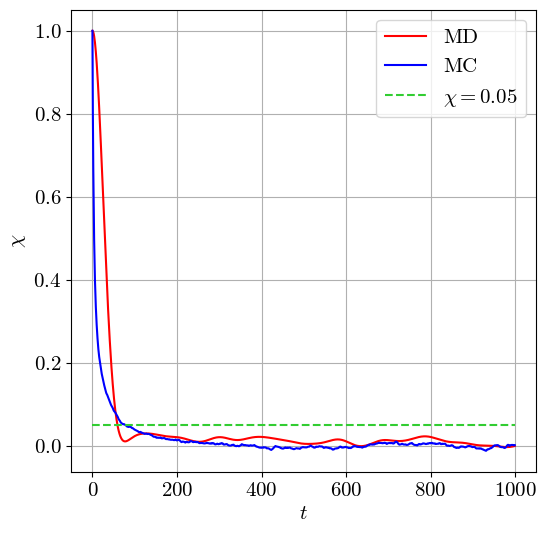

In [32]:
plt.plot(chi[:1000], color='red', label = 'MD')
plt.plot(chi_2[:1000], color='blue', label ='MC')
plt.hlines(0.05,0,1000,linestyles='--',color='limegreen',label='$\chi=0.05$')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\chi$')
plt.grid(True)

In seguito calcoliamo la media a blocchi per i valori di U/N ottenuti dalla simulazione precendente con diversi valori di L (dimensione del blocco) e grafichiamo l'errore al crescere della dimensione del blocco:

In [33]:
N=[50000,25000,20000,15000,10000,7500,5000,2500,2000,1000,750,500,400,250,200,100]


In [34]:

potential = np.loadtxt('NSL_SIMULATOR/OUTPUT/MD/potential_energy_for_acf.dat')
p = potential[:,1]
M = p.size
print(M)

L = np.zeros(len(N), dtype = int)
mean = np.zeros(len(N))
mean2 = np.zeros(len(N))

for i in range(len(N)):
    L[i] = int(M/N[i])
    s = np.zeros(int(N[i]))
    s2 = np.zeros(int(N[i]))
    var = np.zeros(int(N[i]))
    for j in range(len(s)): #ciclo sui blocchi
        for l in range(L[i]): # ciclo nel blocco per fare la media
            s[j] += p[l+j*L[i]]
            s2[j] += p[l+j*L[i]]**2
        s[j] /= L[i]
        s2[j] /= L[i]
        var[j] = (s2[j]-s[j]**2)
    mean[i] = s.mean()
    mean2[i] = np.sqrt(var.mean()/N[i])

500000


In [35]:
#Monte Carlo
potential_MC = np.loadtxt('NSL_SIMULATOR/OUTPUT/MC/potential_energy_for_acf.dat')
p_MC = potential_MC[:,1]
M = p_MC.size
print(M)
L_MC = np.zeros(len(N), dtype = int)
mean_MC = np.zeros(len(N))
mean2_MC = np.zeros(len(N))

for i in range(len(N)):
    L_MC[i] = int(M/N[i])
    s = np.zeros(int(N[i]))
    s2 = np.zeros(int(N[i]))
    var = np.zeros(int(N[i]))
    for j in range(len(s)): #ciclo sui blocchi
        for l in range(L_MC[i]): # ciclo nel blocco per fare la media
            s[j] += p_MC[l+j*L_MC[i]]
            s2[j] += p_MC[l+j*L_MC[i]]**2
        s[j] /= L_MC[i]
        s2[j] /= L_MC[i]
        var[j] = (s2[j]-s[j]**2)
    mean_MC[i] = s.mean()
    mean2_MC[i] = np.sqrt(var.mean()/N[i])   

500000


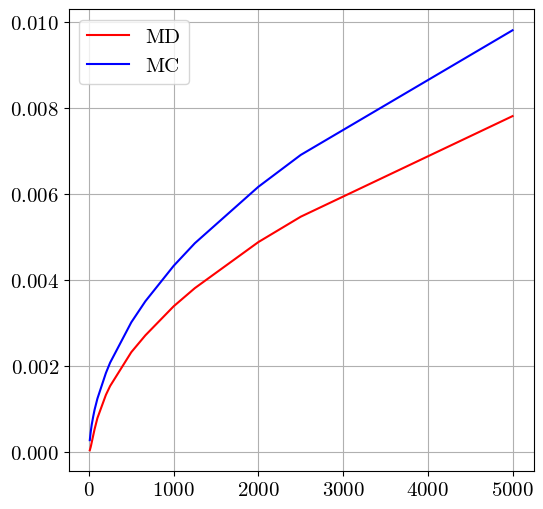

In [36]:
plt.plot(L,mean2, color = 'red', label = 'MD')
plt.plot(L_MC,mean2_MC, color = 'blue', label = 'MC')
plt.legend()
plt.grid(True)

### Exercise 07.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

#### Soluzione 07.3
La funzione di distribuzione radiale $g(r)$ è una funzione di densità di probabilità che misura il numero di particelle che si trovano a una certa distanza ($r$) le une dalle altre. Per implementarla all'interno del codice NSL simulator calcoliamo la distanza tra tutte le coppie di particelle e costruiamo un istogramma suddividendo l'intervallo $\left[ 0; L/2\right]$ in ```_n_bins``` sottointervalli. Per ogni distanza calcolata incrementiamo di 2 (per tener conto di entrambe le particelle della coppia) il conteggio di ogni bin corrispondente.
Una volta calcolata la distanza tra tutte le coppie normalizzo il conteggio dividendo ogni bin per $\rho N \Delta V(r)$ dove $\Delta V(r) = \frac{4\pi}{3} \left[ (r + dr)^3 - r^3 \right]$ è il volume della corona sferica.

Il valore corrispondente a ciascun bin è stato calcolato applicando il data blocking, utilizzando i seguenti parametri:
- $N_{blocks} = 100$
- $N_{steps} = 1000$


Eseguiamo le simulazioni sia in entrambe le modalità MD e MC:

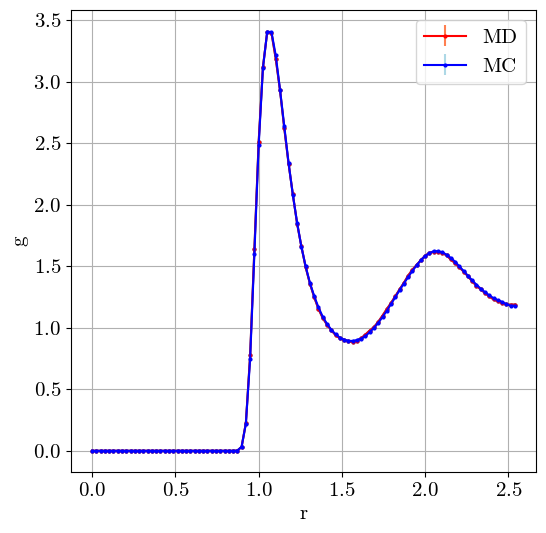

In [39]:
gofr = np.loadtxt("NSL_SIMULATOR/OUTPUT/MD/gofr.dat")
r = gofr[-100:,1]
g = gofr[-100:,2]
err = gofr[-100:,3]

gofr2 = np.loadtxt("NSL_SIMULATOR/OUTPUT/MC/gofr.dat")
r2 = gofr2[-100:,1]
g2 = gofr2[-100:,2]
err2 = gofr2[-100:,3]

plt.plot(r,g, marker = 'o', markersize = '2')
plt.errorbar(r, g,err, marker = 'o', markersize = '2',color='red', ecolor='coral', label = 'MD')
plt.errorbar(r2, g2,err2, marker = 'o', markersize = '2',color='blue', ecolor='lightblue', label = 'MC')
plt.xlabel('r')
plt.ylabel('g')
plt.legend()
plt.grid(True)

### Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and <span style="color:red">perform MC NVT and MD NVE simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... <span style="color:red"> and compare your MC results for these quantities with those obtained via MD NVE simulations in similar thermodynamic conditions.</span>

#### Soluzione 07.4
Eseguiamo le simulazioni sia per MD ch per MC con i parametri richiesti e otteniamo i seguenti grafici per $U/N$, $P$ e $g(r)$:

/tmp/ipykernel_26492/3198615710.py:30: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize =(12,7))


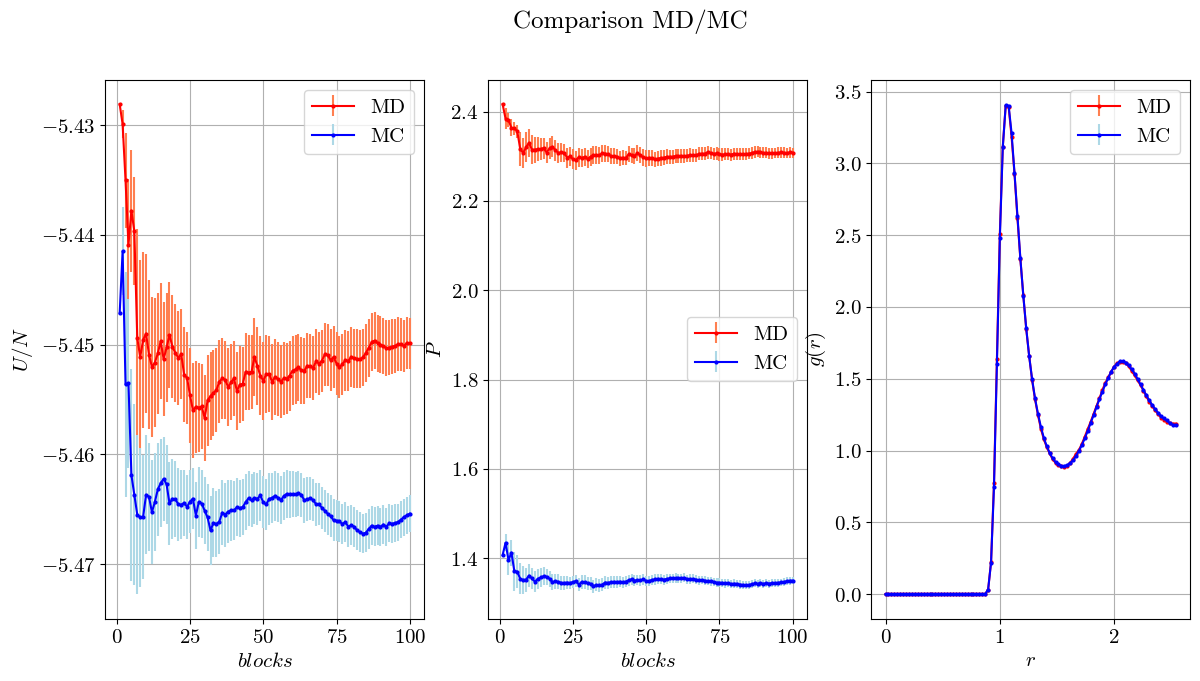

In [2]:
plt.figure(1, figsize=(14,7))

e1 = np.loadtxt("NSL_SIMULATOR/OUTPUT/MD/potential_energy.dat")
x1 = e1[:,0]
y1 = e1[:,2]
err1 = e1[:,3]
e2 = np.loadtxt("NSL_SIMULATOR/OUTPUT/MC/potential_energy.dat")
x2 = e2[:,0]
y2 = e2[:,2]
err2 = e2[:,3]

p1 = np.loadtxt("NSL_SIMULATOR/OUTPUT/MD/pressure.dat")
x3 = p1[:,0]
y3 = p1[:,2]
err3 = p1[:,3]
p2 = np.loadtxt("NSL_SIMULATOR/OUTPUT/MC/pressure.dat")
x4 = p2[:,0]
y4 = p2[:,2]
err4 = p2[:,3]

g1 = np.loadtxt("NSL_SIMULATOR/OUTPUT/MD/gofr.dat")
x5 = g1[-100:,1]
y5 = g1[-100:,2]
err5 = g1[-100:,3]
g2 = np.loadtxt("NSL_SIMULATOR/OUTPUT/MC/gofr.dat")
x6 = g2[-100:,1]
y6 = g2[-100:,2]
err6 = g2[-100:,3]

fig = plt.figure(1, figsize =(12,7))
fig.suptitle('Comparison MD/MC')

plt.subplot(1,3,1)
plt.errorbar(x1,y1,err1, ecolor= 'coral' ,color='red', marker = 'o', markersize = 2, label = 'MD')
plt.errorbar(x2,y2,err2, ecolor= 'lightblue' ,color='blue', marker = 'o', markersize = 2, label = 'MC')
plt.xlabel('$blocks$')
plt.ylabel('$U/N$')
plt.legend()
plt.grid(True)

plt.subplot(1,3,2)
plt.errorbar(x3,y3,err3, ecolor= 'coral' ,color='red', marker = 'o', markersize = 2, label = 'MD')
plt.errorbar(x4,y4,err4, ecolor= 'lightblue' ,color='blue', marker = 'o', markersize = 2, label = 'MC')
plt.xlabel('$blocks$')
plt.ylabel('$P$')
plt.legend()
plt.grid(True)


plt.subplot(1,3,3)
plt.errorbar(x5,y5,err5, ecolor= 'coral' ,color='red', marker = 'o', markersize = 2, label = 'MD')
plt.errorbar(x6,y6,err6, ecolor= 'lightblue' ,color='blue', marker = 'o', markersize = 2, label = 'MC')
plt.xlabel('$r$')
plt.ylabel('$g(r)$')
plt.legend()
plt.grid(True)